<a href="https://colab.research.google.com/github/subhabrata-ghosh-1988/Transformers/blob/main/sarcasm-detection-using-roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sarcasm Detection 

Sarcasm detection unlike sentiment analysis or simple text classification requires a lot of information about human interaction semantics, the model needs to know about how humans actually interact and it also needs to know the context in which certain words are used while being sarcastic and when not sarcastic.

### In this notebook, we will try using the RoberTa classifier.

## BERT - Bidirectional Encoder Representations from Transformers

1. BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. 
2. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. 
3. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. 
4. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which was previously impossible.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/kaggle/input/Sarcasm_Headlines_Dataset_v2.json


In [3]:
!pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [4]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
!pip install transformers
!pip install tokenizers
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 3.4 MB 5.7 MB/s            
     |████████████████████████████████| 67 kB 4.5 MB/s             
     |████████████████████████████████| 895 kB 34.7 MB/s            
     |████████████████████████████████| 596 kB 29.6 MB/s            
     |████████████████████████████████| 3.3 MB 32.0 MB/s            
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [6]:
MODEL_NAME = 'roberta-base'
# MAX_LEN= 256
MAX_LEN= 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [7]:
# MODEL_NAME = 'roberta-base'
# MAX_LEN = 256
# EPOCHS = 3


## 1. Importing Data

In [8]:
df = pd.read_json("/content/kaggle/input/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [9]:
X_data = df[['headline']].to_numpy().reshape(-1)
y_data = df[['is_sarcastic']].to_numpy().reshape(-1)

In [10]:
df.drop('article_link', axis=1, inplace=True)

## 2. Basic Data Cleaning

In [11]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

## 3. Creating the vocabulary

In [13]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock']

In [14]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'area': 494,
 'day': 435,
 'donald': 472,
 'like': 428,
 'man': 1351,
 'new': 1637,
 'one': 527,
 'says': 482,
 'trump': 1284,
 'woman': 483}

## 4. Model Building

In [15]:
X = df['headline']
y = df['is_sarcastic']

In [16]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [17]:
!pip install transformers
## If transformers library is not installed

#### Yinhan Liu et al. introduced the RoBERTa model in RoBERTa: A Robustly Optimized BERT Pretraining Approach. It is built on Google's BERT model, which was released in 2018 but with important hyperparameters changed, such as deleting the next-sentence pretraining target and training with substantially bigger mini-batches and learning rates.

In [18]:

# First load the real tokenizer
#tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
# Save the loaded tokenizer locally
# tokenizer.save_pretrained('.')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [19]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

headlines = df['headline'].unique()
n_headlines = len(headlines)
print('Number of headlines: %d' % n_headlines)

print('Done!')

Texts in dataset: 28619
Number of headlines: 28402
Done!


In [20]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [21]:
# x_train = fast_encode(X_train.values, fast_tokenizer, maxlen=400)
# x_test = fast_encode(X_test.values, fast_tokenizer, maxlen=400)

In [22]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

We shall be using the pre-trained BERT model which has been extensively trained on huge text corpuses of Wikipedia.
Now after getting the pre-trained model, we can fine-tune the model for our own specific task.

The key thing to notice is here is that for our final prediction we would only be using the output generated by the first token ([CLS]), after which we use a sigmoid activation for final prediction.

In [23]:
# def build_model(transformer, max_len=400):
    
#     input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
#     sequence_output = transformer(input_word_ids)[0]
#     cls_token = sequence_output[:, 0, :]
#     out = Dense(1, activation='sigmoid')(cls_token)
    
#     model = Model(inputs=input_word_ids, outputs=out)
#     model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# Create RoBERTa model

In [24]:
def build_model(n_headlines):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_headlines, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [25]:
with strategy.scope():
    model = build_model(n_headlines)
    model.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

# Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [26]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3
2505/2505 [==============================] - 2603s 1s/step - loss: 0.3423 - accuracy: 0.8780 - val_loss: 0.1911 - val_accuracy: 0.9242
Epoch 2/3
2505/2505 [==============================] - 2574s 1s/step - loss: 0.1402 - accuracy: 0.9465 - val_loss: 0.2638 - val_accuracy: 0.9089
Epoch 3/3
2505/2505 [==============================] - 2560s 1s/step - loss: 0.0844 - accuracy: 0.9680 - val_loss: 0.2694 - val_accuracy: 0.9222


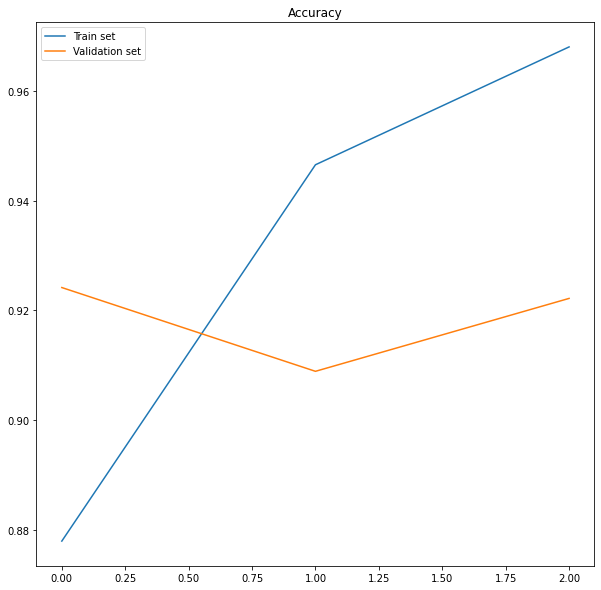

In [27]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

# Evaluation
In a confusion matrix, we can see how many categories are classified c



In [28]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
y_pred = [np.argmax(i) for i in model.predict(X_test)]

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      4458
           1       0.96      0.88      0.92      4128

    accuracy                           0.92      8586
   macro avg       0.93      0.92      0.92      8586
weighted avg       0.92      0.92      0.92      8586



In [31]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[4297,  161],
       [ 507, 3621]])

Text(69.0, 0.5, 'Actual')

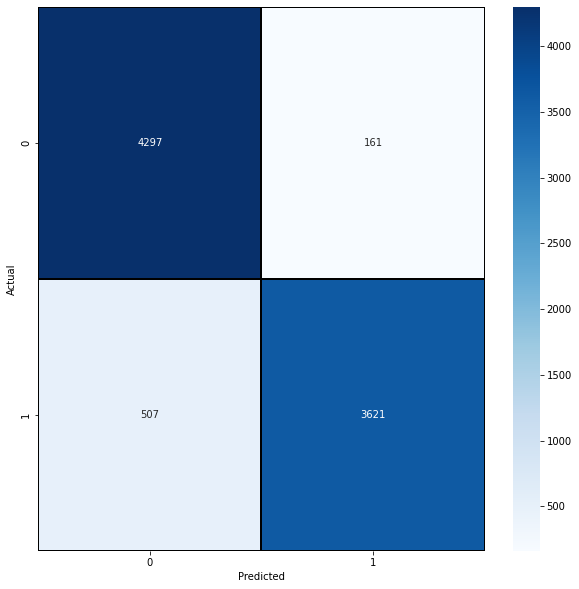

In [32]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [33]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 92.22%


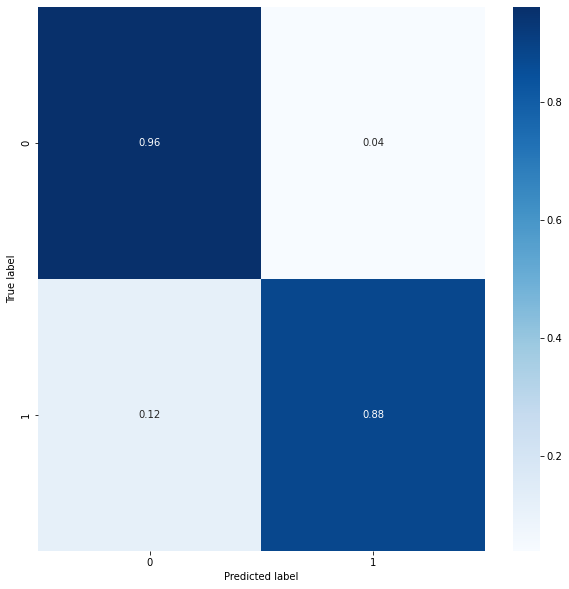

In [34]:
plot_confusion_matrix(X_test, y_test, model)

Downloading the pre-trained BERT model.
We can use either the CASED or the UNCASED version for model building.

To explain the BERT training in simple words:
The BERT pre-training consists of two steps which happen parallely, these include:
### 1. Masked Language Model
In this the model is provided with sentences and some of the words are masked with a [MASK] tag (15% of all words), the model is then asked to predict those masked words. The BERT loss function takes into consideration only the prediction of the masked values and ignores the prediction of the non-masked words. As a consequence, the model converges slower than directional models, a characteristic which is offset by its increased context awareness.

### 2. Next Sentence Prediction
In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. This helps the model to understand the relationships between

In [35]:
# bert_model = transformers.TFRobertaModel.from_pretrained('roberta-base')

In [36]:
# model = build_model(bert_model, max_len=400)
# model.summary()

In [37]:
# history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)

In [38]:
# print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [39]:
# epochs = [i for i in range(3)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

# ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
# ax[0].set_title('Training & Testing Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
# ax[1].set_title('Training & Testing Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Loss")
# plt.show()

In [40]:
# pred = model.predict(x_test)
# pred[:5]

In [41]:
# pred = np.round(pred).astype(int)
# pred[:5]

In [42]:
# print(classification_report(y_test, pred))

In [43]:
# cm = confusion_matrix(y_test,pred)
# cm

In [44]:
# plt.figure(figsize = (10,10))
# sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
# plt.xlabel("Predicted")
# plt.ylabel("Actual")